In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import os 
import tensorflow as tf
import numpy as np

from src.layers.attention import HeadAttentionMulti, scaled_dot_product_attention
from src.data.loaders import get_loader
from src.metrics.r2 import custom_r2
from src.losses import custom_rmse, rmse_for_nsp
from src.data.zero import pretraining_pipeline
from src.metrics import custom_r2

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2

2024-03-15 16:08:23.058108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# train_loader = pretraining_pipeline('./data/records/atlas/fold_0/atlas_20/train/',
#                                     batch_size= 5,
#                                     window_size=200,
#                                     shuffle=True,
#                                     sampling=True,
#                                     repeat=4,
#                                     msk_frac=.5,
#                                     rnd_frac=.2,
#                                     same_frac=.2)

In [49]:
# ========== DATA ========================================
data_loader = get_loader('./data/records/alcock/fold_0/alcock_20/train/',
                          batch_size=2000,
                          window_size=200,
                          probed_frac=.9,
                          random_frac=.0,
                          nsp_prob=.5,
                          sampling=True,
                          shuffle=True,
                          repeat=1,
                          aversion='base')

[INFO] Probed: 0.90 Random: 0.00 Same: 0.00
[INFO] Repeating dataset x1 times
[INFO] Sampling random windows
[INFO] Loading PT task: Masking


(96, 200, 1)
(96, 200, 1)
(96, 200, 1)
(96, 200, 1)


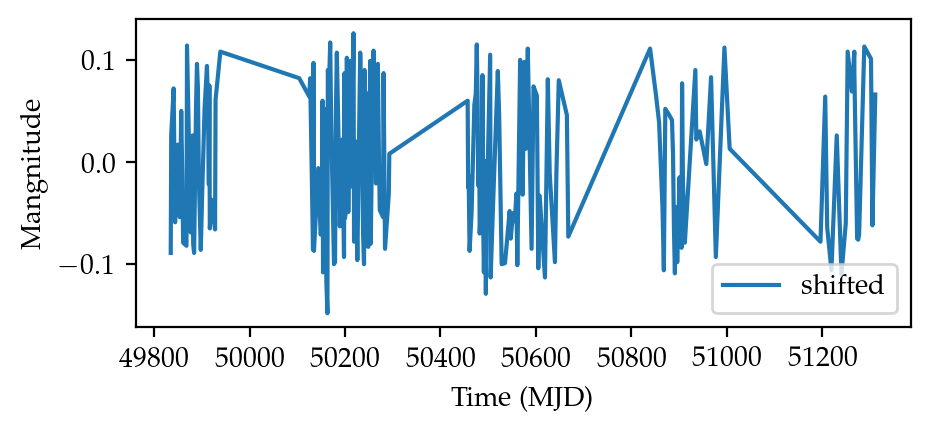

In [50]:
for x, y in data_loader.take(1):
    for a in x.keys():
        print(x[a].shape)
    plt.figure(figsize=(5, 2), dpi=200)
    plt.plot(x['times'][0], x['input'][0], label='shifted')
    
    print(y['w_error'].shape)
    plt.legend()
    plt.ylabel('Mangnitude')
    plt.xlabel('Time (MJD)')
    plt.show()

In [51]:
from src.models.astromer_1 import get_ASTROMER

In [52]:
# ======= MODEL ========================================
model = get_ASTROMER(num_layers=2,
                     num_heads=4,
                     head_dim=32,
                     mixer_size=128,
                     dropout=0.,
                     pe_base=1000,
                     pe_dim=256,
                     pe_c=1,
                     window_size=200,
                     mask_format='Q',
                     use_leak=True)

[INFO] Masking Query tokens only
[INFO] Masking Query tokens only


In [53]:
model.summary()

Model: "ASTROMER-1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 magnitudes (InputLayer)        [(None, 200, 1)]     0           []                               
                                                                                                  
 att_mask (InputLayer)          [(None, 200, 1)]     0           []                               
                                                                                                  
 times (InputLayer)             [(None, 200, 1)]     0           []                               
                                                                                                  
 encoder (MaskTokenEncoder)     (None, 200, 128)     331264      ['magnitudes[0][0]',             
                                                                  'att_mask[0][0]',      

In [54]:
# for x, y in data_loader.take(1):
#     print(y['probed_mask'])
#     print(y.keys())

[INFO] Masking Query tokens only
[INFO] Masking Query tokens only
tf.Tensor(0.7110832, shape=(), dtype=float32)


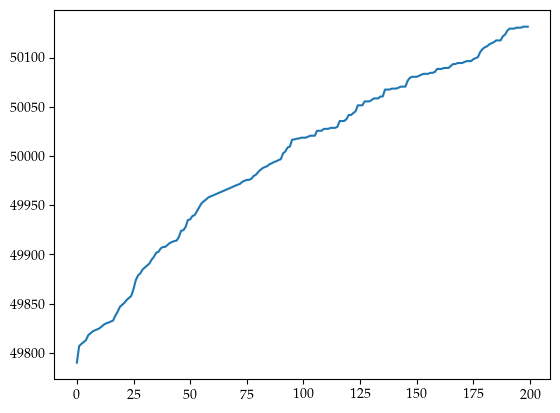

In [64]:
for x, y in data_loader.take(1):
    plt.plot(x['times'][0])
    pred = model(x)
    val_rmse = custom_rmse(y['target'], pred, mask=y['mask_out'], weights=y['w_error'])
    val_r2 = custom_r2(y['target'], pred, mask=y['mask_out'])
#     print(val_r2, val_rmse)
    print(val_rmse)

In [70]:
for x, y in data_loader.take(1):

    q = tf.random.uniform([tf.shape(x['att_mask'])[0], 4, tf.shape(x['att_mask'])[1], 32])
    k = tf.random.uniform([tf.shape(x['att_mask'])[0], 4, tf.shape(x['att_mask'])[1], 32])
    v = tf.random.uniform([tf.shape(x['att_mask'])[0], 4, tf.shape(x['att_mask'])[1], 32])
    
    output, weights, mask = scaled_dot_product_attention(q, k, v, 
                                                         mask=x['att_mask'], 
                                                         return_mask=True)

In [71]:
mask.shape, weights.shape

(TensorShape([2000, 1, 200, 200]), TensorShape([2000, 4, 200, 200]))

tf.Tensor([0. 0. 0. 0. 0. 1. 1. 0. 1. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 1. 0. 1. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 1. 0. 1. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 1. 0. 1. 0.], shape=(10,), dtype=float32)


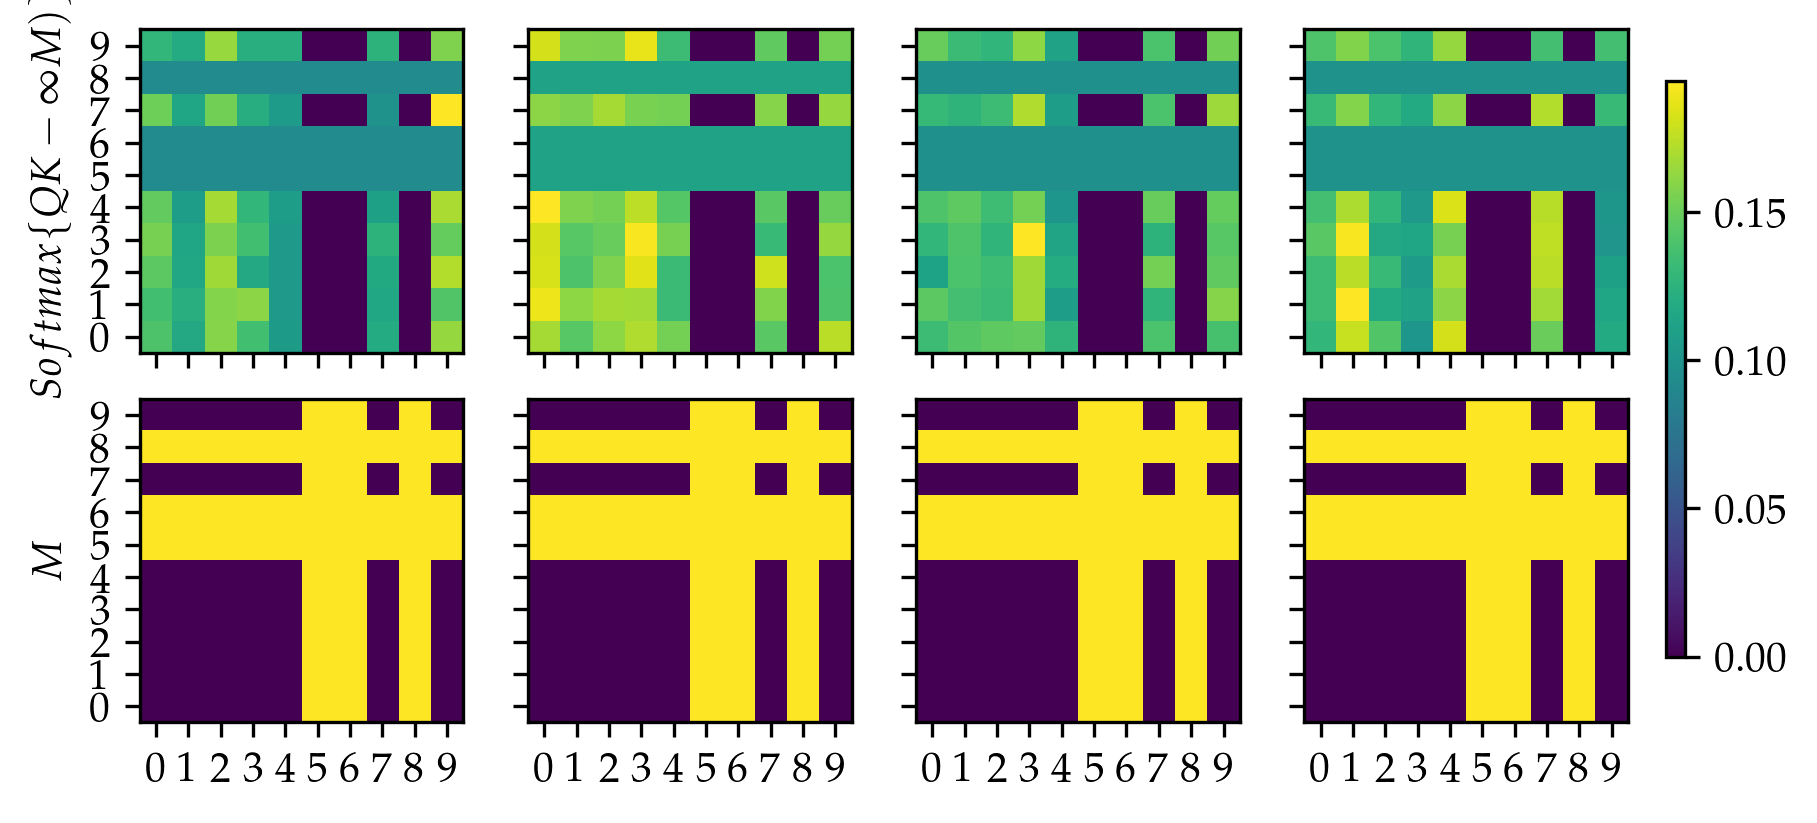

In [93]:
fig, axes = plt.subplots(2, 4, dpi=300, 
                         gridspec_kw={'hspace': -0.5, 'wspace': 0.2}, 
                         sharex=True, sharey=True)
for i in range(4):
    print(x['att_mask'][0, :, 0])
    prod = weights*(1.-mask)
    im = axes[0][i].imshow(weights[0, i], extent=(0, 10, 0, 10))
    axes[0][i].set_xticks(range(10))
    axes[0][i].set_yticks(range(10))


    axes[1][i].imshow(mask[0, 0], extent=(0, 10, 0, 10))
    
    for k in range(2):
        axes[k][i].set_xticks(np.arange(0.5, 10.5))
        axes[k][i].set_yticks(np.arange(0.5, 10.5))
        axes[k][i].set_xticklabels(np.arange(0, 10))
        axes[k][i].set_yticklabels(np.arange(0, 10))
    
    axes[0][0].set_ylabel(r'$Softmax{\{QK-\infty M)\}}$')
    axes[1][0].set_ylabel(r'$M$')
    
cbar_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
fig.colorbar(im, cax=cbar_ax)

In [11]:
model = get_ASTROMER(window_size=10)
for x, y in data.take(1):
    y_pred = model(x)
    

In [12]:
custom_r2(y['magnitudes'], y_pred, y['probed_mask'])

<tf.Tensor: shape=(), dtype=float32, numpy=-52.31381>